In [10]:
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Dataset
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import KFold

In [2]:
# Set device: use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define transforms for train, validation, and test
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),  # rotate by ±10 degrees
    transforms.RandomResizedCrop(250, scale=(0.9, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((250, 250)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

Using device: cuda


In [11]:
# Create a custom Dataset wrapper to apply transforms to a subset
class TransformSubset(Dataset):
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)

dataset_path = 'Rice_Image_Dataset'
if not os.path.isdir(dataset_path):
    raise FileNotFoundError(f"Dataset folder '{dataset_path}' not found.")

# Load the full dataset without applying any transform yet
full_dataset = ImageFolder(root=dataset_path, transform=None)
print("Classes:", full_dataset.classes)

# Shuffle and split: 80% train, and the remaining 20% will be split into 80% validation and 20% test.
total_size = len(full_dataset)
train_size = int(0.8 * total_size)
remainder = total_size - train_size
test_size = int(0.2 * remainder)  # 20% of the remaining 20%
val_size = remainder - test_size   # rest for validation

# Random split the dataset
train_subset, remainder_subset = random_split(full_dataset, [train_size, remainder])
val_subset, test_subset = random_split(remainder_subset, [val_size, test_size])

print(f"Total images: {total_size}")
print(f"Training images: {len(train_subset)}")
print(f"Validation images: {len(val_subset)}")
print(f"Test images: {len(test_subset)}")

# Wrap the subsets with the proper transforms
train_dataset = TransformSubset(train_subset, train_transform)
val_dataset = TransformSubset(val_subset, val_test_transform)
test_dataset = TransformSubset(test_subset, val_test_transform)

# Create DataLoaders with reduced batch size and num_workers set to 0 for debugging.
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)


Classes: ['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']
Total images: 75000
Training images: 60000
Validation images: 12000
Test images: 3000


In [12]:
# Define the CNN model
class RiceCNN(nn.Module):
    def __init__(self):
        super(RiceCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 250x250 -> 125x125

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 125x125 -> ~62x62

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),  # ~62x62 -> ~31x31

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2)   # ~31x31 -> ~15x15
        )
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.6),  # Increased dropout for regularization
            nn.Linear(128, 5)  # 5 classes for rice types
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [13]:
# Instantiate the model and move it to the device
model = RiceCNN().to(device)
print(model)

# Define loss function and optimizer with weight decay for regularization.
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Early stopping parameters
num_epochs = 30  # Maximum epochs (training may stop earlier)
patience = 3   # Number of epochs to wait for improvement before stopping
best_val_loss = float('inf')
early_stopping_counter = 0

# Training and validation loop with detailed logging and timing per epoch
for epoch in range(num_epochs):
    epoch_start = time.time()
    
    # Training phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        # Log progress every 50 batches
        if batch_idx % 50 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx}/{len(train_loader)}] processed...")
    
    train_loss = running_loss / total
    train_acc = 100.0 * correct / total
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()
    val_loss /= val_total
    val_acc = 100.0 * val_correct / val_total
    
    epoch_time = time.time() - epoch_start
    print(f"Epoch [{epoch+1}/{num_epochs}] completed in {epoch_time:.2f} seconds.")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    
    # Early stopping check based on validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stopping_counter = 0
        # Save the best model so far
        torch.save(model.state_dict(), 'best_rice_cnn.pth')
        print("Validation loss improved, saving model...")
    else:
        early_stopping_counter += 1
        print(f"Validation loss did not improve. Early stopping counter: {early_stopping_counter}/{patience}")
        if early_stopping_counter >= patience:
            print("Early stopping triggered!")
            break

# Optionally, save the final model if needed
torch.save(model.state_dict(), 'rice_cnn_final.pth')
print("Final model saved as rice_cnn_final.pth")

# ------------------------------
# Testing phase: Evaluate the best model on the test set
# ------------------------------
# Load the best model (saved based on validation loss)
best_model = RiceCNN().to(device)
best_model.load_state_dict(torch.load('best_rice_cnn.pth', map_location=device, weights_only=True))
best_model.eval()

test_loss = 0.0
test_correct = 0
test_total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = best_model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

test_loss /= test_total
test_acc = 100.0 * test_correct / test_total
print(f"Best Model Test Loss: {test_loss:.4f}, Best Model Test Acc: {test_acc:.2f}%")

RiceCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

              precision    recall  f1-score   support

     Arborio       1.00      1.00      1.00       605
     Basmati       1.00      0.99      1.00       589
      Ipsala       1.00      1.00      1.00       623
     Jasmine       1.00      1.00      1.00       608
   Karacadag       1.00      1.00      1.00       575

    accuracy                           1.00      3000
   macro avg       1.00      1.00      1.00      3000
weighted avg       1.00      1.00      1.00      3000



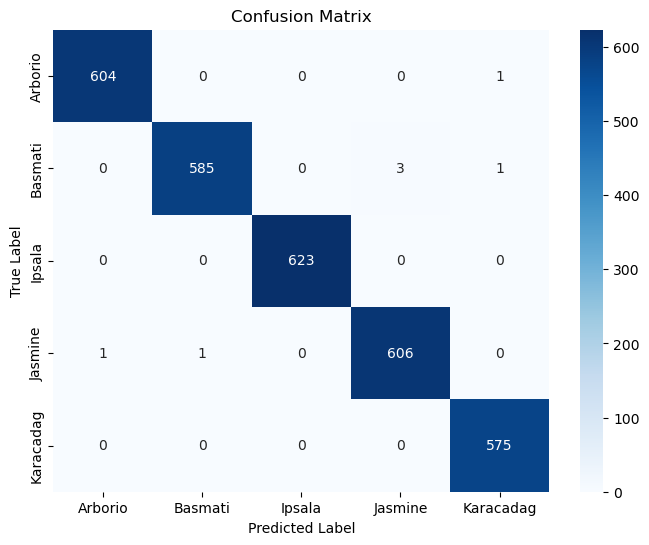

In [14]:
model = RiceCNN().to(device)
model.load_state_dict(torch.load('best_rice_cnn.pth', map_location=device))
model.eval()

# Gather predictions and true labels from the test set
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute classification report: precision, recall, F1 score for each class.
target_names = full_dataset.classes  # assuming full_dataset is defined and contains the classes
print(classification_report(all_labels, all_preds, target_names=target_names))

# Compute and plot the confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', 
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [15]:
# ------------------------------
# 1. Define the Transformations and Load the Dataset
# ------------------------------
transform = transforms.Compose([
    transforms.Resize((250, 250)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

dataset = ImageFolder(root='Rice_Image_Dataset', transform=transform)
print("Classes:", dataset.classes)
print("Total images:", len(dataset))

# ------------------------------
# 2. Define the RiceCNN Model
# ------------------------------
class RiceCNN(nn.Module):
    def __init__(self):
        super(RiceCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 250x250 -> 125x125

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 125x125 -> ~62x62

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),  # ~62x62 -> ~31x31

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2)   # ~31x31 -> ~15x15
        )
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.6),
            nn.Linear(128, 5)  # 5 classes for rice types
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# ------------------------------
# 3. Set Up k-Fold Cross Validation for Evaluation
# ------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
indices = np.arange(len(dataset))
fold_accuracies = []

# ------------------------------
# 4. Cross-Validation Loop: Evaluate Saved Model on Each Validation Fold
# ------------------------------
for fold, (_, val_idx) in enumerate(kf.split(indices)):
    print(f"\n--- Fold {fold+1}/{k_folds} ---")
    # Create a validation subset for the current fold
    val_subset = Subset(dataset, val_idx)
    val_loader = DataLoader(val_subset, batch_size=32, shuffle=False, num_workers=2)
    
    # Initialize model and load the saved best weights
    model = RiceCNN().to(device)
    model.load_state_dict(torch.load("best_rice_cnn.pth", map_location=device,weights_only=True))
    model.eval()
    
    total, correct = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
    
    fold_accuracy = 100.0 * correct / total
    fold_accuracies.append(fold_accuracy)
    print(f"Fold {fold+1} Accuracy: {fold_accuracy:.2f}%")

avg_accuracy = np.mean(fold_accuracies)
print(f"\nAverage Validation Accuracy over {k_folds} folds: {avg_accuracy:.2f}%")


Classes: ['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']
Total images: 75000
Using device: cuda

--- Fold 1/5 ---
Fold 1 Accuracy: 99.76%

--- Fold 2/5 ---
Fold 2 Accuracy: 99.85%

--- Fold 3/5 ---
Fold 3 Accuracy: 99.79%

--- Fold 4/5 ---
Fold 4 Accuracy: 99.83%

--- Fold 5/5 ---
Fold 5 Accuracy: 99.85%

Average Validation Accuracy over 5 folds: 99.81%
